<a href="https://colab.research.google.com/github/abagnard/266FinalProject/blob/main/W266_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os, sys, re, csv, json, time, unittest
import itertools, collections
from importlib import reload

import pandas as pd
import numpy as np
from scipy import stats

# Data Scraper Packages
from   bs4    import BeautifulSoup
from   urllib.request import urlopen

# Clean Data Packages
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import glob

# FOMC Data Loader

In [11]:
# Pull Dates of FOMC meetings
df_date = pd.read_csv("data/FOMC_data/FOMC_meeting_dates.csv")
meeting_dates = df_date["MeetingDate"].values.tolist()

## Create DataFrame with Clean Data
- Includes press_conference flag that denotes whether a press conference was held for that FOMC meeting

In [12]:
clean_file_names = glob.glob('data/FOMC_data/FOMC_data_clean/*.txt')

FOMC_records = []
for clean_file_name in clean_file_names:
    meeting_date = clean_file_name.split('/')[-1].split('_')[-1][:-4]
    press_conference = df_date[df_date['MeetingDate'] == int(meeting_date)].iloc[0]['PressConference']
    data = open(clean_file_name).read()
    
    if 'Minutes' in clean_file_name:
        file_type = 'minutes'
        release_date = df_date[df_date['MeetingDate'] == int(meeting_date)].iloc[0]['MinuteNotesReleaseDate']
        # Pull data without stopwords
        file_name = clean_file_name[-24:]
        data_without_stopwords = open('data/FOMC_data/FOMC_data_clean/FOMC_data_clean_without_stopwords/' + file_name).read()
    
    else:
        file_type = 'statement'
        release_date = meeting_date
        # Pull data without stopwords        
        file_name = clean_file_name[-26:]
        data_without_stopwords = open('data/FOMC_data/FOMC_data_clean/FOMC_data_clean_without_stopwords/' + file_name).read()
    
    FOMC_record = {'FOMC_date': meeting_date, 'release_date': release_date, 'document_type': file_type, 'press_conference': press_conference, 'document_data': data, 'document_data_wo_stopwords': data_without_stopwords}
    FOMC_records.append(FOMC_record)


df_FOMC_raw = pd.DataFrame(FOMC_records)

In [15]:
df_FOMC_raw.FOMC_date = pd.to_datetime(df_FOMC_raw.FOMC_date, format='%Y%m%d')
df_FOMC_raw.release_date = pd.to_datetime(df_FOMC_raw.release_date, format='%Y%m%d')

df_FOMC_raw.head()
# df_FOMC_raw.describe(include='all')
# df_FOMC_raw.dtypes

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date
0,2006-01-31,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,minutes,0,2006-02-21
1,2000-10-03,for immediate release the FOMC at its meeting ...,immediate release FOMC meeting today decided m...,statement,0,2000-10-03
2,2000-03-21,for immediate release the FOMC voted today to ...,immediate release FOMC voted today raise targe...,statement,0,2000-03-21
3,2011-01-26,information received since the FOMC met in dec...,information received since FOMC met december c...,statement,0,2011-01-26
4,2002-11-06,for immediate release the FOMC decided today t...,immediate release FOMC decided today lower tar...,statement,0,2002-11-06


## Add Lables to DataFrame
- Label_Data file includes code on how we caluclate our data lables

In [16]:
df_market_data_lables = pd.read_csv('data/Market_data/market_data_labels_by_date.csv', parse_dates=['Date'])
df_market_data_lables.head()

,Date,open,high,low,close,volume,prevclose,pct_change_in_close,fed_rate,prev_fed_rate,pct_change_in_fed_rate,5_yr,7_yr,10_yr,20_yr,30_yr,prev_10_yr,pct_change_in_10_yr,label
0,2003-01-02,88.85,91.30,88.54,91.07,44516300,88.23,3.218860,1.30,1.16,10.769231,1.75,2.24,2.43,NaN,NaN,NaN,NaN,0
1,2003-01-03,90.91,91.38,90.50,91.35,32222600,91.07,0.307456,1.12,1.30,-16.071429,1.75,2.25,2.43,NaN,NaN,2.43,0.000000,1
2,2003-01-06,91.24,93.49,91.17,92.96,40984500,91.35,1.762452,1.22,1.12,8.196721,1.79,2.27,2.46,NaN,NaN,2.43,1.219512,3
3,2003-01-07,92.90,93.37,92.20,92.73,38640400,92.96,-0.247418,1.20,1.22,-1.666667,1.76,2.24,2.42,NaN,NaN,2.46,-1.652893,-3
4,2003-01-08,92.20,92.40,91.05,91.39,38702200,92.73,-1.445056,1.29,1.20,6.976744,1.68,2.14,2.29,NaN,NaN,2.42,-5.676856,-1


In [17]:
df_FOMC_labeled =  pd.merge(df_FOMC_raw, df_market_data_lables, left_on='release_date', right_on='Date')

In [18]:
df_FOMC_labeled.head()

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date,Date,open,high,low,...,prev_fed_rate,pct_change_in_fed_rate,5_yr,7_yr,10_yr,20_yr,30_yr,prev_10_yr,pct_change_in_10_yr,label
0,2006-01-31,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,minutes,0,2006-02-21,2006-02-21,129.11,129.40,128.29,...,4.48,1.321586,1.97,2.01,2.04,2.01,NaN,2.03,0.490196,1
1,2011-01-26,information received since the FOMC met in dec...,information received since FOMC met december c...,statement,0,2011-01-26,2011-01-26,129.49,130.05,129.23,...,0.17,0.000000,0.07,0.65,1.16,1.82,2.07,1.11,4.310345,2
2,2013-06-19,information received since the FOMC met in may...,information received since FOMC met may sugges...,statement,1,2013-06-19,2013-06-19,165.60,165.89,163.38,...,0.12,-20.000000,-0.59,-0.19,0.29,1.05,1.26,0.14,51.724138,-1
3,2017-07-26,minutes of the FOMC july 25 26 2017 a joint me...,minutes FOMC july 25 26 2017 joint meeting FOM...,minutes,0,2017-08-16,2017-08-16,247.11,247.57,246.45,...,1.16,0.000000,0.17,0.34,0.45,0.75,0.94,0.49,-8.888889,0
4,2003-06-25,for immediate release the FOMC decided today t...,immediate release FOMC decided today lower tar...,statement,0,2003-06-25,2003-06-25,98.53,99.44,97.53,...,1.15,2.542373,0.87,1.31,1.71,NaN,NaN,1.68,1.754386,1


In [19]:
df_FOMC_labeled_small = df_FOMC_labeled[['FOMC_date', 'document_data', 'document_data_wo_stopwords','document_type', 'press_conference', 'release_date','label']].copy()
df_FOMC = df_FOMC_labeled_small
df_FOMC.head()

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date,label
0,2006-01-31,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,minutes,0,2006-02-21,1
1,2011-01-26,information received since the FOMC met in dec...,information received since FOMC met december c...,statement,0,2011-01-26,2
2,2013-06-19,information received since the FOMC met in may...,information received since FOMC met may sugges...,statement,1,2013-06-19,-1
3,2017-07-26,minutes of the FOMC july 25 26 2017 a joint me...,minutes FOMC july 25 26 2017 joint meeting FOM...,minutes,0,2017-08-16,0
4,2003-06-25,for immediate release the FOMC decided today t...,immediate release FOMC decided today lower tar...,statement,0,2003-06-25,1


# Top 20 Most Common Words

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 20)

# ALL Documents
cv.fit(df_FOMC['document_data_wo_stopwords'])
top_20_words_all = cv.get_feature_names()

top_20_words_all = pd.DataFrame(top_20_words_all)
top_20_words_all.columns = ['Top 20 Words']
top_20_words_all['top_word_ranking'] = top_20_words_all.reset_index().index
top_20_words_all

# Statements Only
statements = df_FOMC[df_FOMC['document_type'] == 'statement']
cv.fit(statements['document_data_wo_stopwords'])
top_20_words_statement = cv.get_feature_names()

top_20_words_statement = pd.DataFrame(top_20_words_statement)
top_20_words_statement.columns = ['Statment Top 20 Words']
top_20_words_statement['top_word_ranking'] = top_20_words_statement.reset_index().index
top_20_words_statement

# Minutes Only
minutes = df_FOMC[df_FOMC['document_type'] == 'minutes']
cv.fit(minutes['document_data_wo_stopwords'])
top_20_words_minutes = cv.get_feature_names()

top_20_words_minutes = pd.DataFrame(top_20_words_minutes)
top_20_words_minutes.columns = ['Minutes Top 20 Words']
top_20_words_minutes['top_word_ranking'] = top_20_words_minutes.reset_index().index
top_20_words_minutes

column_names = ['top_word_ranking', 'Top 20 Words', 'Statment Top 20 Words','Minutes Top 20 Words']

# top_20 = pd.DataFrame(results.toarray(). columns=features)
top_20_words_all.merge(top_20_words_statement, left_on='top_word_ranking', right_on='top_word_ranking').merge(top_20_words_minutes, left_on='top_word_ranking', right_on='top_word_ranking')[column_names]

,top_word_ranking,Top 20 Words,Statment Top 20 Words,Minutes Top 20 Words
0,0,board,committee,board
1,1,committee,conditions,committee
2,2,conditions,economic,conditions
3,3,continued,employment,continued
4,4,economic,federal,economic
5,5,federal,financial,federal
6,6,financial,funds,financial
7,7,growth,growth,growth
8,8,inflation,inflation,inflation
9,9,labor,labor,market


# FOMC Word Cloud

### FOMC Statements & Minutes Word Cloud

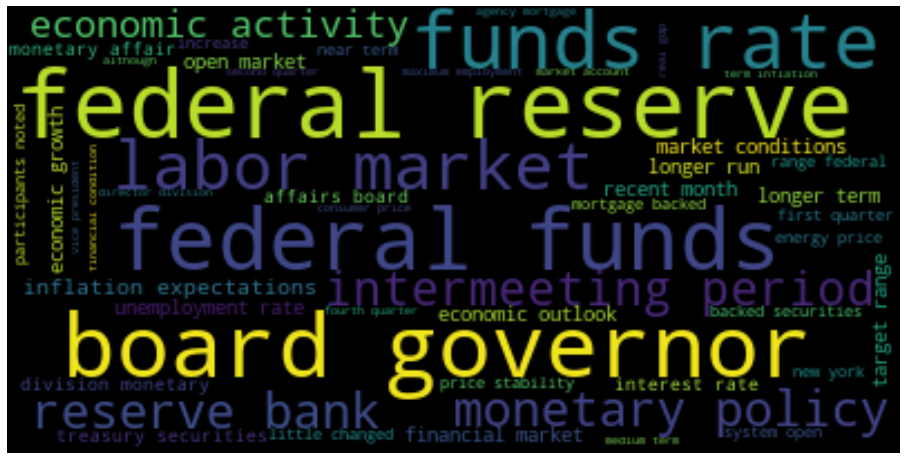

In [23]:
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

text = ' '.join(df_FOMC['document_data_wo_stopwords'])
wordcloud = WordCloud(max_words=50).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/all_FOMC_docs_wordcloud.png")

### FOMC Statements Word Cloud

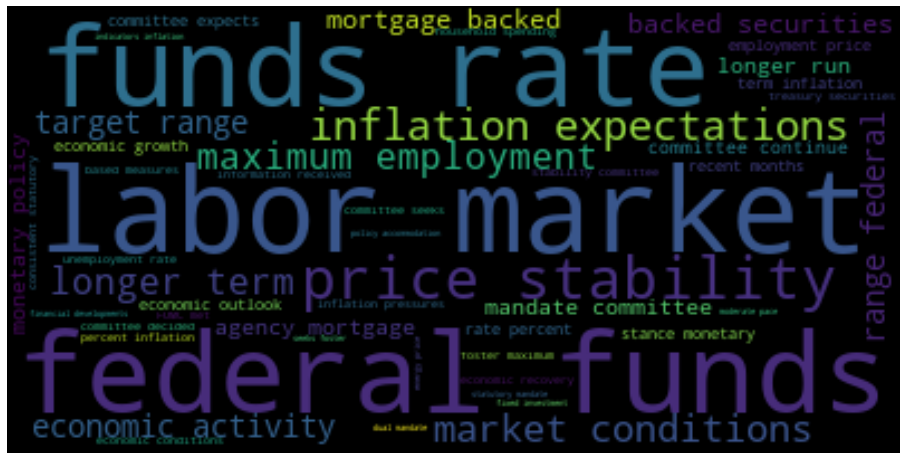

In [24]:
statements = df_FOMC[df_FOMC['document_type'] == 'statement']

plt.figure(figsize=(16, 10))

statement_text = ' '.join(statements['document_data_wo_stopwords'])
statement_wordcloud = WordCloud(max_words=50).generate(statement_text)
plt.imshow(statement_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_statements_wordcloud.png")

### FOMC Minutes Word Cloud

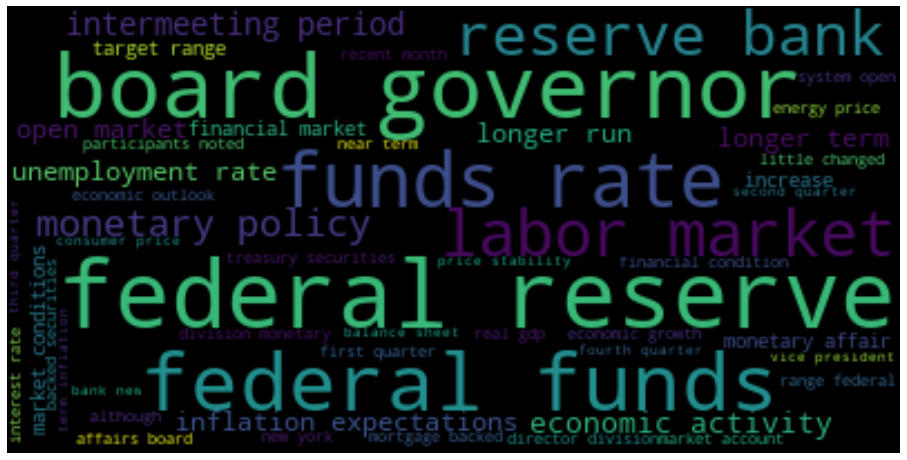

In [25]:
minutes = df_FOMC[df_FOMC['document_type'] == 'minutes']

plt.figure(figsize=(16, 10))

minute_text = ' '.join(minutes['document_data_wo_stopwords'])
minute_wordcloud = WordCloud(max_words=50).generate(minute_text)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(minute_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

# Document Sentiment Analysis

#### Load Loughran-McDonald Postive & Negative Word Lists
source: https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists

In [26]:
df_FOMC_sentiment = df_FOMC

In [27]:
def createLoughranMcDonaldWordList(file_name):
    file = open('data/LoughranMcDonald/'+file_name, "r")
    words = file.readlines()
    words = [word.strip().lower() for word in words]
    return words

LM_negative_words = createLoughranMcDonaldWordList('LoughranMcDonald_NegativeWordList.csv')
LM_postive_words = createLoughranMcDonaldWordList('LoughranMcDonald_PositiveWordList.csv')

#### Count Positive and Negative Words in Each Document to Calculate Sentiment Score

In [28]:
def calcSentiment(document_data):
    words = document_data.split(' ')
    positive_words = [word for word in words if word in LM_postive_words]
    negative_words = [word for word in words if word in LM_negative_words]
    positive_count = len(positive_words)
    negative_count = len(negative_words)
    LM_sentiment_score = (positive_count) - negative_count
    return [LM_sentiment_score, positive_count, negative_count, positive_words, negative_words]

# df_FOMC_sentiment['num_LM_positive_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[1])
# df_FOMC_sentiment['num_LM_negative_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[2])
df_FOMC_sentiment['LM_sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[0])
df_FOMC_sentiment['LM_positive_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[3])
df_FOMC_sentiment['LM_netagive_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[4])

#### Add Label Each Document Based on Sentiment Score

In [29]:
def calcSentimentLabel(LM_sentiment_score):
    LM_sentiment_label = 'neutral'
    
    if LM_sentiment_score < -5:
        LM_sentiment_label = 'negative'
    elif LM_sentiment_score > 5:
        LM_sentiment_label = 'positive'
        
    return LM_sentiment_label
    
df_FOMC_sentiment['LM_sentiment_label'] = df_FOMC_sentiment['LM_sentiment_score'].apply(lambda score: calcSentimentLabel(score))

In [30]:
df_FOMC_sentiment.sort_values(['FOMC_date', 'document_type']).head()

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date,label,LM_sentiment_score,LM_positive_words,LM_netagive_words,LM_sentiment_label
239,2002-12-10,minutes of the FOMC december 10 2002 a meeting...,minutes FOMC december 10 2002 meeting FOMC hel...,minutes,0,2003-01-30,-1,-45,"[strong, gains, gains, strong, despite, boom, ...","[sluggish, late, downward, declined, stagnant,...",negative
12,2003-01-29,minutes of the FOMC january 28 29 2003 a meeti...,minutes FOMC january 28 29 2003 meeting FOMC h...,minutes,0,2003-03-20,3,-48,"[pleasure, satisfactory, effective, effective,...","[discontinuance, cease, limitations, limitatio...",negative
147,2003-01-29,for immediate release the FOMC decided today t...,immediate release FOMC decided today keep targ...,statement,0,2003-01-29,3,1,"[improving, stability]",[against],neutral
256,2003-03-18,minutes of the FOMC march 18 2003 a meeting of...,minutes FOMC march 18 2003 meeting FOMC held o...,minutes,0,2003-05-08,-3,-55,"[boosted, gain, gains, strength, gains, gains,...","[slowed, sluggish, declining, weakened, sharpl...",negative
110,2003-03-18,for immediate release the FOMC decided today t...,immediate release FOMC decided today keep targ...,statement,0,2003-03-18,1,2,"[improving, stability, informative]",[disappointing],neutral


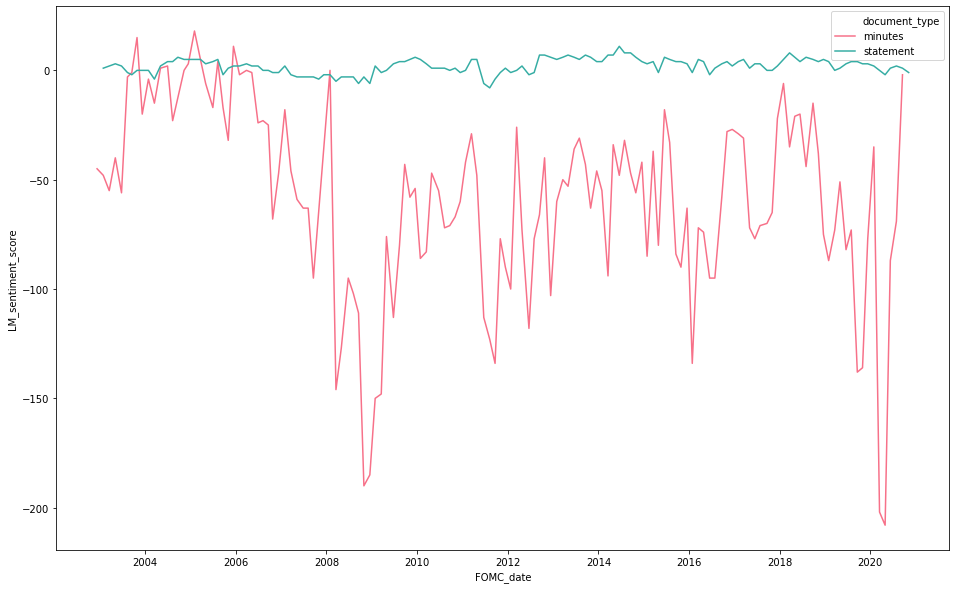

In [36]:
import seaborn as sns
colors = sns.color_palette('husl', n_colors =2)
color_map = dict(zip(['minutes','statement'], colors))

plt.figure(figsize=(16, 10))
sns.lineplot(x=df_FOMC_sentiment['FOMC_date'], y=df_FOMC_sentiment['LM_sentiment_score'], hue=df_FOMC['document_type'], palette=color_map)


In [37]:
df_FOMC_sentiment['LM_sentiment_label'].value_counts()

neutral     131
negative    127
positive     23
Name: LM_sentiment_label, dtype: int64

Text(0.5, 0, 'LM_sentiment_label')

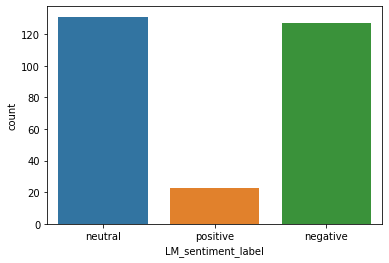

In [46]:
sns.countplot(df_FOMC_sentiment['LM_sentiment_label'])
plt.xlabel('LM_sentiment_label')

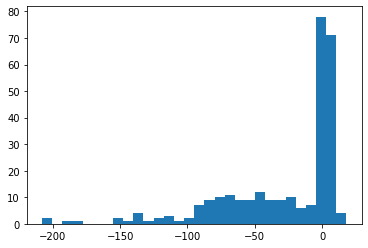

In [51]:
plt.hist(df_FOMC_sentiment['LM_sentiment_score'],  30)
plt.show()


### FOMC Statement Positive + Negative Words Only Word Cloud

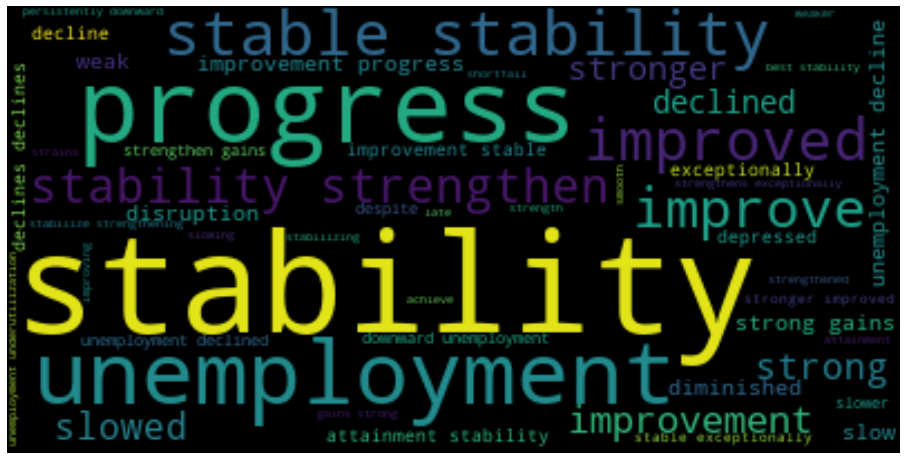

In [32]:
statement = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'statement']

plt.figure(figsize=(16, 10))

positive_words = ' '.join(statement['LM_positive_words'].apply(lambda words: ' '.join(words)))
negative_words = ' '.join(statement['LM_netagive_words'].apply(lambda words: ' '.join(words)))
words = positive_words + negative_words
words_wordcloud = WordCloud(max_words=50).generate(words)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(words_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

### FOMC Minutes Positive + Negative Words Only Word Cloud

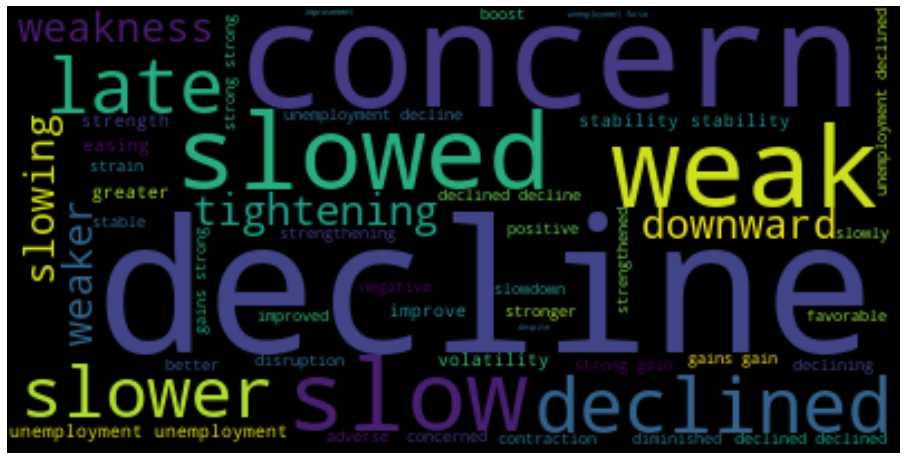

In [33]:
minutes = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'minutes']

plt.figure(figsize=(16, 10))

positive_words = ' '.join(minutes['LM_positive_words'].apply(lambda words: ' '.join(words)))
negative_words = ' '.join(minutes['LM_netagive_words'].apply(lambda words: ' '.join(words)))
words = positive_words + negative_words
words_wordcloud = WordCloud(max_words=50).generate(words)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(words_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

# Pretrained FinBERT Sentiment Analysis

In [34]:
## Load required packages
# pip install torch torchvision
# pip install torch==1.7.0 -f https://download.pytorch.org/whl/torch_stable.html

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
# import numpy as np

In [35]:
## Downloads pretrained finBERT model

tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")

In [49]:
def finBERTModelPreTrained(review_text):
    MAX_LEN = 512
    class_names = ['negative', 'neutral', 'positive']

    encoded_new = tokenizer.encode_plus(
                            review_text,                      # Sentence to encode.
                            add_special_tokens = True,        # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LEN,             # Pad & truncate all sentences.
                            padding = 'longest',
                            truncation=True,
                            return_attention_mask = True,     # Construct attn. masks.
                            return_tensors = 'pt',            # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    input_idst = (encoded_new['input_ids'])
    attention_maskst = (encoded_new['attention_mask'])

    # Convert the lists into tensors.
    input_idst = torch.cat([input_idst], dim=0)
    attention_maskst = torch.cat([attention_maskst], dim=0)

    new_test_output = model(input_idst, token_type_ids=None, 
                          attention_mask=attention_maskst)

    logits = new_test_output[0]
    predicted = logits.detach().numpy()

    # Store predictions
    flat_predictions = np.concatenate(predicted, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    new_predictions = np.argmax(flat_predictions).flatten()

    return class_names[new_predictions[0]]

### Pretrained FinBERT Model on Entire Document

In [50]:
df_FOMC_sentiment['FinBERT_pretrained_sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: finBERTModelPreTrained(data))



In [52]:
# df_FOMC_sentiment.groupby(['document_type', 'FinBERT_pretrained_sentiment_score', 'label']).count()
df_FOMC_sentiment.groupby(['document_type', 'LM_sentiment_label', 'FinBERT_pretrained_sentiment_score']).count()


FOMC_date  \
document_type LM_sentiment_label FinBERT_pretrained_sentiment_score              
minutes       negative           neutral                                   123   
              neutral            neutral                                    14   
              positive           neutral                                     3   
statement     negative           neutral                                     3   
                                 positive                                    1   
              neutral            negative                                    4   
                                 neutral                                    48   
                                 positive                                   65   
              positive           neutral                                     1   
                                 positive                                   19   

                                                                     document_data  \
document_type LM_sentiment_label FinBERT_pretrained_sentiment_score                  
minutes       negative           neutral                                       123   
              neutral            neutral                                        14   
              positive           neutral                                         3   
statement     negative           neutral                                         3   
                                 positive                                        1   
              neutral            negative                                        4   
                                 neutral                                        48   
                                 positive                                       65   
              positive           neutral                                         1   
                                 positive                                       19   

                                                                     document_data_wo_stopwords  \
document_type LM_sentiment_label FinBERT_pretrained_sentiment_score                               
minutes       negative           neutral                                                    123   
              neutral            neutral                                                     14   
              positive           neutral                                                      3   
statement     negative           neutral                                                      3   
                                 positive                                                     1   
              neutral            negative                                                     4   
                                 neutral                                                     48   
                                 positive                                                    65   
              positive           neutral                                                      1   
                                 positive                                                    19   

                                                                     press_conference  \
document_type LM_sentiment_label FinBERT_pretrained_sentiment_score                     
minutes       negative           neutral                                          123   
              neutral            neutral                                           14   
              positive           neutral                                            3   
statement     negative           neutral                                            3   
                                 positive                                           1   
              neutral            negative                                           4   
                                 neutral                                           48   
                                 positive                    

In [53]:
df_FOMC_sentiment['FinBERT_pretrained_sentiment_score'].value_counts()

neutral     192
positive     85
negative      4
Name: FinBERT_pretrained_sentiment_score, dtype: int64

Text(0.5, 0, 'FinBERT_pretrained_sentiment_score')

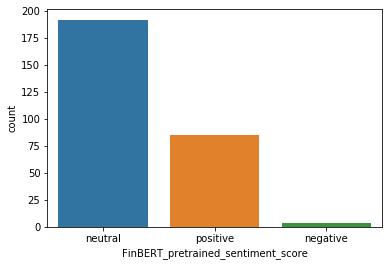

In [54]:
sns.countplot(df_FOMC_sentiment['FinBERT_pretrained_sentiment_score'])
plt.xlabel('FinBERT_pretrained_sentiment_score')

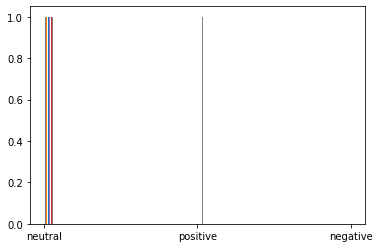

In [55]:
# plt.figure(figsize=(30,20))
# sns.countplot(df_FOMC_sentiment['LM_sentiment_score'])
# plt.xlabel('LM_sentiment_score')

plt.hist(df_FOMC_sentiment['FinBERT_pretrained_sentiment_score'],  30)
plt.show()

### Correlation Between LM Sentiment Label and Pretrained FinBERT Model Sentiment Label

In [56]:
LM_sentiment_label = df_FOMC_sentiment['LM_sentiment_label'].astype('category').cat.codes
FinBERT_pretrained_sentiment_score = df_FOMC_sentiment['FinBERT_pretrained_sentiment_score'].astype('category').cat.codes

correlation = LM_sentiment_label.corr(FinBERT_pretrained_sentiment_score) 

print('Correlation Between LM Sentiment and FinBERT Pretrained Sentiment')
print(correlation)

Correlation Between LM Sentiment and FinBERT Pretrained Sentiment
0.5607531969929399


### Confusion Matrix Between LM Sentiment Label and Pretrained FinBERT Model Sentiment Label

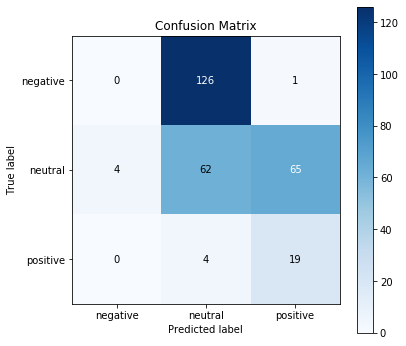

In [57]:
# !pip install scikit-plot
import scikitplot as skplt

true_label = df_FOMC_sentiment['LM_sentiment_label']
predicted_label = df_FOMC_sentiment['FinBERT_pretrained_sentiment_score']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

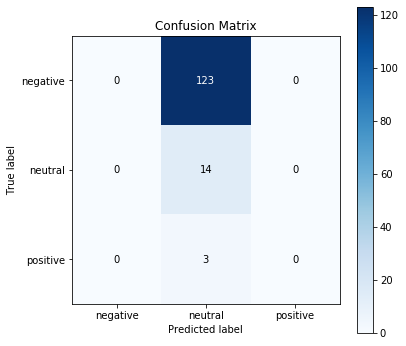

In [58]:
minutes_sentiment = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'minutes']
true_label = minutes_sentiment['LM_sentiment_label']
predicted_label = minutes_sentiment['FinBERT_pretrained_sentiment_score']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

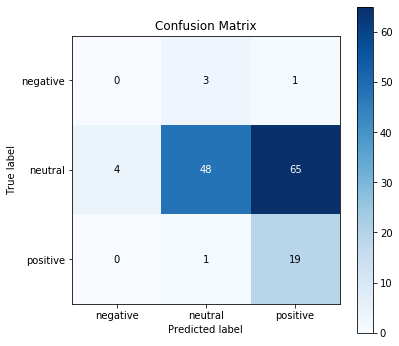

In [59]:
statement_sentiment = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'statement']
true_label = statement_sentiment['LM_sentiment_label']
predicted_label = statement_sentiment['FinBERT_pretrained_sentiment_score']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

In [60]:
def update_label_to_num(str):
    if(str=='positive'):
        return 1
    elif(str=='neutral'):
        return 0
    else:
        return -1

df_FOMC_sentiment_test = df_FOMC_sentiment
    
df_FOMC_sentiment_test['LM_label'] = df_FOMC_sentiment_test['LM_sentiment_label'].apply(update_label_to_num)
df_FOMC_sentiment_test['FinBERT_label'] = df_FOMC_sentiment_test['FinBERT_pretrained_sentiment_score'].apply(update_label_to_num)


true = df_FOMC_sentiment_test['LM_label'].tolist()
predicted = df_FOMC_sentiment_test['FinBERT_label'].tolist()


In [61]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
mat = sklearn.metrics.confusion_matrix(true , predicted)
mat


array([[  0, 126,   1],
       [  4,  62,  65],
       [  0,   4,  19]])

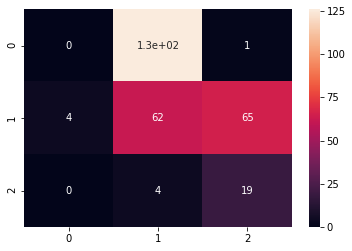

In [62]:
df_cm = pd.DataFrame(mat, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [66]:
print(sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       127
     neutral       0.32      0.47      0.38       131
    positive       0.22      0.83      0.35        23

    accuracy                           0.29       281
   macro avg       0.18      0.43      0.25       281
weighted avg       0.17      0.29      0.21       281



In [67]:
sklearn.metrics.accuracy_score(true,predicted)

0.28825622775800713

# Create CSV of df_FOMC_sentiment for Colab

In [292]:
smaller_df = df_FOMC_sentiment[['FOMC_date', 'document_data', 'document_type', 'press_conference','release_date', 'label','LM_sentiment_score','LM_sentiment_label','FinBERT_pretrained_sentiment_score']]
# smaller_df.head()

# smaller_df.to_csv("data_for_colab.csv")


### Pretrained FinBERT Model on Each Sentence

In [95]:
from nltk import tokenize

def FinBERTModel_sentences(document):
    sentences = tokenize.sent_tokenize(document)
    sentiment_score = 0
    for sentence in sentences:
        sentiment = finBERTModelPreTrained(sentence)
        if sentiment == 'negative':
            sentiment_score -= 1
        elif sentiment == 'positive':
            sentiment_score += 1
    return sentiment_score

# df_FOMC['by_sentence_FinBERT_sentiment_score'] = df_FOMC['document_data'].apply(lambda data: FinBERTModel_sentences(data))



### Pretrained FinBERT Model Output Review

In [304]:
# df_FOMC.groupby(['document_type', 'FinBERT_sentiment_score', 'by_sentence_FinBERT_sentiment_score','LM_sentiment_score']).count()


# FinBERT Sentiment Analysis

In [80]:
# pip install pytorch_pretrained_bert
# pip install finbert-embedding==0.1.4

In [79]:
# from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE
# from pytorch_pretrained_bert.modeling import BertForSequenceClassification
# from pytorch_pretrained_bert.tokenization import BertTokenizer
# from pytorch_pretrained_bert.optimization import *

# from finbert_embedding.embedding import *

In [148]:
# WATCH VIDEO
# https://towardsdatascience.com/how-nlp-has-evolved-for-financial-sentiment-analysis-fb2990d9b3ed

In [149]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [152]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [186]:
model = BertForSequenceClassification.from_pretrained('finBERT/pytorch_model.bin', config = 'finBERT/config.json', num_labels = 3)

label_lists = ['positive', 'negative', 'neutral']

# RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
# 	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
# 	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
    # FIX: add num_labels=3 to the parameters above

### Simple Tests for Accuracy

In [182]:
# TESTS
inputs = tokenizer("We had a good year", return_tensors="pt")
outputs = model(**inputs)
outputs
# Ouputs = [positive, negative, neutral]

label_lists[torch.argmax(outputs[0])]

'positive'

In [184]:
# TESTS
inputs = tokenizer("We had a bad year", return_tensors="pt")
outputs = model(**inputs)
label_lists[torch.argmax(outputs[0])]

'negative'

In [187]:
# TESTS
inputs = tokenizer("We had a neutral year", return_tensors="pt")
outputs = model(**inputs)
label_lists[torch.argmax(outputs[0])]

'neutral'

### Run Data through Model

In [193]:
def runFinBERT(document):
    inputs = tokenizer(document, return_tensors="pt", truncation = True, max_length = 512)
    outputs = model(**inputs)
    return label_lists[torch.argmax(outputs[0])]

In [194]:
df_FOMC_sentiment['FinBERT_video_sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: runFinBERT(data))

# RuntimeError: The size of tensor a (5261) must match the size of tensor b (512) at non-singleton dimension 1
    # too many tokens in data...need to truncate or shorten the data into smaller subsections of length 512 and less
    # if you truncate, you need to add truncation = True and max_length = 512 as a parameter in your tokenizer 

In [196]:
df_FOMC_sentiment.groupby(['document_type', 'FinBERT_video_sentiment_score','FinBERT_pretrained_sentiment_score', 'label']).count()

# loss = outputs.loss
# logits = outputs.logits

FOMC_date  \
document_type FinBERT_video_sentiment_score FinBERT_pretrained_sentiment_score label              
minutes       neutral                       neutral                            -3             3   
                                                                               -2            20   
                                                                               -1             7   
                                                                                0            23   
                                                                                1             6   
                                                                                2            25   
                                                                                3             2   
statement     neutral                       negative                           -3             1   
                                                                               -1             1   
                                                                                0             1   
                                            neutral                            -3             2   
                                                                               -2             9   
                                                                               -1             4   
                                                                                0            19   
                                                                                1             2   
                                                                                2             4   
                                                                                3             1   
                                            positive                           -3             1   
                                                                               -2             3   
                                                                               -1             5   
                                                                                0            16   
                                                                                1             1   
                                                                                2            12   
                                                                                3             2   
              positive                      positive                            2             1   

                                                                                      document_data  \
document_type FinBERT_video_sentiment_score FinBERT_pretrained_sentiment_score label                  
minutes       neutral                       neutral                            -3                 3   
                                                                               -2                20   
                                                                               -1                 7   
                                                                                0                23   
                                                                                1                 6   
                                                                                2                25   
                                                                                3                 2   
statement     neutral                       negative                           -3                 1   
                                                                               -1                 1   
                                                                                0                 1   
                                            neutral                            -3                 2   
                                                                         

In [198]:
df_FOMC_sentiment.groupby(['label']).count()

,FOMC_date,document_data,document_type,press_conference,release_date,sentiment_score,LM_positive_words,LM_netagive_words,FinBERT_pretrained_sentiment_score,FinBERT_video_sentiment_score
label,,,,,,,,,,
-3,7,7,7,7,7,7,7,7,7,7
-2,32,32,32,32,32,32,32,32,32,32
-1,17,17,17,17,17,17,17,17,17,17
0,59,59,59,59,59,59,59,59,59,59
1,9,9,9,9,9,9,9,9,9,9
2,42,42,42,42,42,42,42,42,42,42
3,5,5,5,5,5,5,5,5,5,5


# BERT Model

In [149]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [257]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [258]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)
label_lists = ['positive', 'negative', 'neutral']

# RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
# 	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
# 	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
    # FIX: add num_labels=3 to the parameters above

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def train_bert(model, tokenizer):
    